In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 2a)

Computing the solution to the equation
$$\beta b^3 \frac{db}{dz} = \alpha b^3 - Q$$
which represents the steady state of the equations handled in part 1.

A Forward Euler method is used for the discretisation.

In [3]:
# Functions to solve the equation

# Calculating the b value at z given knowledge of the value at z - dz.
def steady_iteration(Q: float, alpha: float, beta: float, bPrev: float, 
                     dz: float) -> float:
    b = bPrev + dz * (alpha * bPrev**3 - Q) / (beta * bPrev**3)
    return b

# Solves the steady state equation for the range of z from 0 to H
def solve_steady(alpha: float, beta: float, Q: float, H: float, 
                 J: int, b0: float) -> pd.DataFrame:
    """
    Solving the steady state equation using a forward euler method.
    Parameters:
    ----------
    alpha : float
        Parameter alpha in the equation.
    beta : float
        Parameter beta in the equation.
    Q : float
        Parameter Q in the equation.
    H : float
        The height of the domain.
    J : int
        The number of steps in the z direction.
    b0 : float
        The boundary condition at z = 0.
    Returns:
    -------
    pd.DataFrame
        A dataframe with two columns: z and b, where z is the position
        in the domain and b is the corresponding value of b at that position.
    """

    # Initialize the array to store the values of b at each step
    b_values = [b0]
    dz = H / J

    # Iteratively apply the update scheme to compute b at each step
    for j in range(1, J + 1):
        b_next = steady_iteration(Q, alpha, beta, b_values[-1], dz)
        b_values.append(b_next)

    # Create a 2 column table of z againsst b values 
    z_values = [j * dz for j in range(J + 1)]
    result: list[tuple[float, float]] = list(zip(z_values, b_values))
    df = pd.DataFrame(result, columns=["z", "b"])

    return df

In [4]:
# Defining Parameters

Q = 0.99
alpha = 0.4709
beta = 1 
H = 1
bB = 1.178164343

In [5]:
# Solving the steady state equation for the given parameters
steady_solution: pd.DataFrame = solve_steady(alpha, beta, Q, H, 1000, bB)

In [6]:
steady_solution

,z,b
0,0.000,1.178164
1,0.001,1.178030
2,0.002,1.177895
3,0.003,1.177760
4,0.004,1.177625
...,...,...
996,0.996,0.605585
997,0.997,0.601598
998,0.998,0.597522
999,0.999,0.593352


In [7]:
def dimension_plot(figure: plt.Figure, axis: plt.Axes, df: pd.DataFrame, 
                   label_width: str, label_height: str, title: str):
    # Calculate width/2 and -width/2 arrays
    width_half = df[label_width] / 2
    print(width_half)
    neg_width_half = -df[label_width] / 2

    axis.plot(width_half, df[label_height], color='blue')
    axis.plot(neg_width_half, df[label_height], color='blue')
    axis.set_xlabel(label_width)
    axis.set_ylabel(label_height)
    axis.legend()
    figure.tight_layout()
    axis.set_title(title)
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0       0.589082
1       0.589015
2       0.588948
3       0.588880
4       0.588813
          ...   
996     0.302792
997     0.300799
998     0.298761
999     0.296676
1000    0.294542
Name: b, Length: 1001, dtype: float64


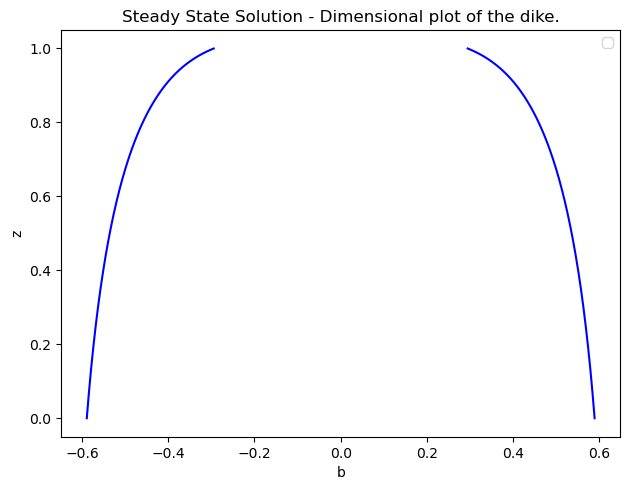

In [8]:
# Plot the dimension plot of the steady solution#
fig, ax = plt.subplots()
dimension_plot(fig, ax, steady_solution, "b", "z", "Steady State Solution - Dimensional plot of the dike.")


### 2b)

Using the numerical scheme from part 1 to find a numerical solution to
$$\frac{\partial b}{\partial t} + \frac{\partial}{\partial x}(\alpha b^3 - \beta b^3 \frac{\partial b}{\partial x}) = 0$$

for a variety of grid sizes.

We solve using the linearised scheme where $D_0 := b_T$ and as such $b = b' + D_0$. We would assume that perturbation $b' << D_0$ however this does not hold in this case.


In [9]:
# IGNORE: Functions for solving the time-dependent scheme

# One iteration of the time dependent scheme
def linearised_time_d_iteration(bPrev: list[float], alpha: float, b0: float, 
                     beta: float, dz: float, dt: float):
    # Note that bPrev is the points from the previous time step at j-1, j and j+1 where we are 
    # calculating for the current time step at position j
    bNext: float = bPrev[1] - dt * (3 * alpha * b0 ** 2 * (bPrev[1] - bPrev[0]) / dz 
                             - beta * b0 ** 3 * (bPrev[2] - 2 * bPrev[1] + bPrev[0]) / dz**2)
    return bNext

def linear_solve_time_dependent(alpha: float, beta: float, H: float, 
                         b0: float, bT: float, J: int, dt: float, max_time: float = 2.5):
    # Solving the time dependent problem considering perturbations from a constant start
    # value bT at t = 0 with boundary conditions b(0, t) = b0 and b(H, t) = bT.
    # Note the possibility of discontinuity at z = 0 at t = 0.
    # Note also that the b_values array is initially translated to take into account that
    # we are solving for perturbations from bT, i.e. b = b' + bT where b' is the solution
    # we are calculating.

    # Initialize arrays
    dz: float = H / J
    print(f'dz: {dz}')

    # Calculate the upper bound on dt for stability
    time_step_limit(alpha, beta, b0, dt, dz)

    z_values: list[float] = [j * dz for j in range(J + 1)]
    b_values: list[list[float]] = [[0 for _ in range(J + 1)]]  # Initial condition: b(z, 0) = b0 for all z, t in the first index, z in the second index

    time_steps = int(max_time / dt)
    print(f'Time steps: {time_steps}')
    for time_step in range(time_steps):
        # Initialize the next time step array with boundary condition
        b_next: list[float] = [b0 - bT] + [0.0 for _ in range(1, J)] + [0]
        for j in range(1, J):
            b_next[j] = linearised_time_d_iteration(b_values[-1][j-1:j+2], alpha, b0, beta, dz, dt)
        b_values.append(b_next)

    time_values: list[float] = [n * dt for n in range(len(b_values))]

    # Adjust all the b_values back up by bT
    for n in range(len(b_values)):
        for j in range(len(b_values[n])):
            b_values[n][j] += bT
        
    return z_values, time_values, b_values

def time_step_limit(alpha, beta, b0, dt, dz):
    dt_stable: float = dz**2 / (3 * dz * alpha * b0**2 + 2 * beta * b0 ** 3)
    print(f"Stable dt: {dt_stable}, Given dt: {dt}")

### Non-linearized Numerical Scheme

For the full non-linear equation, the numerical iteration scheme is:

$$b_j^{n+1} = b_j^n - \Delta t \left[ \frac{\alpha}{\Delta z}((b_j^{n})^3 - (b_{j-1}^{n})^3) - \frac{\beta}{8\Delta z^2}\left((b_{j+1}^n + b_j^n)^3(b_{j+1}^n - b_j^n) - (b_j^n + b_{j-1}^n)^3(b_j^n - b_{j-1}^n)\right) \right]$$

where:
- $b_j^n$ represents the solution at position $j$ and time step $n$
- The first term handles the advection part $\alpha b^3$
- The second term handles the diffusion part $\beta b^3 \frac{\partial b}{\partial x}$ using a central difference approximation

In [36]:
# Functions for calculating the numerical scheme with the non-linearised 
# equations

def time_iteration(bPrev: list[float], alpha: float, b0: float, 
                     beta: float, dz: float, dt: float, verbosity = 0):
    # Note that bPrev is the points from the previous time step at j-1, j and j+1 where we are 
    # calculating for the current time step at position j

    convection = (alpha / dz) * (bPrev[1] ** 3 - bPrev[0] ** 3)
    diffusion = beta * ((bPrev[2] + bPrev[1]) ** 3 
                        * (bPrev[2] - bPrev[1]) 
                        - (bPrev[1] + bPrev[0]) ** 3 
                        * (bPrev[1] - bPrev[0])) / (8 * dz ** 2)
    if verbosity > 0:
        print(f'Convection: {convection}, Diffusion: {diffusion}, dt: {dt}, bPrev: {bPrev}')
    bNext: float = bPrev[1] - dt * (convection - diffusion)
    
    return bNext

def nonlinear_solve_time_dependent(alpha: float, beta: float, H: float, 
                         b0: float, bT: float, J: int, dt: float, max_time: float = 3, 
                         initial: list[float] = None, verbosity = 0):
    # Solving the time dependent problem considering perturbations from a constant start
    # value bT at t = 0 with boundary conditions b(0, t) = b0 and b(H, t) = bT.
    # Note the possibility of discontinuity at z = 0 at t = 0.

    # Initialize arrays
    dz: float = H / J
    print(f'dz: {dz}')

    # Calculate the upper bound on dt for stability
    time_step_limit(alpha, beta, b0, dt, dz)

    z_values: list[float] = [j * dz for j in range(J + 1)]
    b_values: list[list[float]] = [[bT for _ in range(J + 1)]]  # Initial condition: b(z, 0) = b0 for all z, t in the first index, z in the second index
    if initial is not None:
        b_values[0] = initial

    time_steps = int(max_time / dt)
    print(f'Time steps: {time_steps}')
    for time_step in range(time_steps):
        # Initialize the next time step array with boundary condition
        b_next: list[float] = [b0] + [0.0 for _ in range(1, J)] + [bT]
        for j in range(1, J):
            b_next[j] = time_iteration(b_values[-1][j-1:j+2], alpha, b0, beta, dz, dt)
        b_values.append(b_next)

    time_values: list[float] = [n * dt for n in range(len(b_values))]

    return z_values, time_values, b_values

In [45]:
# Parameters
grid_spacings = [5, 11, 21, 41, 81]
dt = 1e-5
bT = 0.585373798


In [46]:
# Solve the time dependent problem

solutions = []
for grid in grid_spacings:
    z_vals, t_vals, b_vals = nonlinear_solve_time_dependent(alpha, beta, H, bB, bT, grid, dt)
    solutions.append((grid, z_vals, t_vals, b_vals))

dz: 0.2
Stable dt: 0.010920196727129326, Given dt: 1e-05
Time steps: 300000
dz: 0.09090909090909091
Stable dt: 0.0023961783475749702, Given dt: 1e-05
Time steps: 300000
dz: 0.047619047619047616
Stable dt: 0.0006740446977058817, Given dt: 1e-05
Time steps: 300000
dz: 0.024390243902439025
Stable dt: 0.0001792586221928934, Given dt: 1e-05
Time steps: 300000
dz: 0.012345679012345678
Stable dt: 4.6257236202375483e-05, Given dt: 1e-05
Time steps: 300000


## Postprocessing

Extracting specific times from the data and plotting the dimension plots for each of the different grid sizes.

In [47]:
# Extracting solution at specific times
times = [0.05, 0.1, 0.2, 0.5, 1, 2]

# Finding the index of the time values closest to the specified times
time_indices = []
time_list = solutions[0][2]  # All solutions have the same time values
for t in times:
    closest_index = min(range(len(time_list)), key=lambda i: abs(time_list[i] - t))
    time_indices.append(closest_index)

# Extract the solution at the time indices into a df for each grid size

# Initialise df with first column z values and then column names as time values
extracted_solutions = []
for solution in solutions:
    grid, z_vals, t_vals, b_vals = solution
    data = {'z': z_vals}
    for idx in time_indices:
        data[f't={t_vals[idx]:.2f}'] = [b_vals[idx][j] for j in range(len(z_vals))]
    df = pd.DataFrame(data)
    extracted_solutions.append((grid, df))

# Add the steady solution to each df
# Note that the steady solution is calculated on a grid of 1000 points so we need to find the nearest value

for i in range(len(extracted_solutions)):
    grid, df = extracted_solutions[i]
    steady_data = []
    for z in df['z']:
        # Use the fact of even spacing between 0 and H to find the nearest index
        index = int(z / H * 1000)
        steady_data.append(steady_solution['b'][index])
    
    df['steady'] = steady_data
    extracted_solutions[i] = (grid, df)



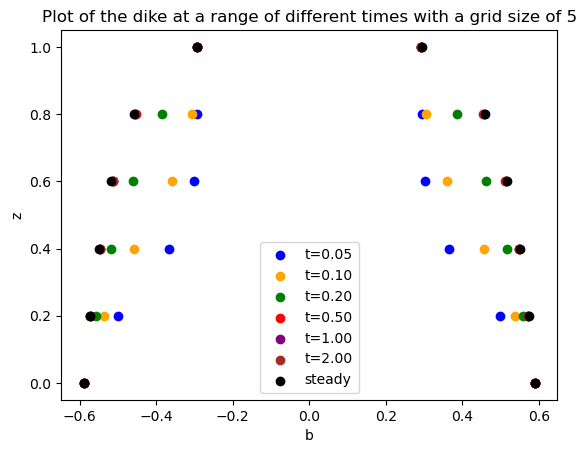

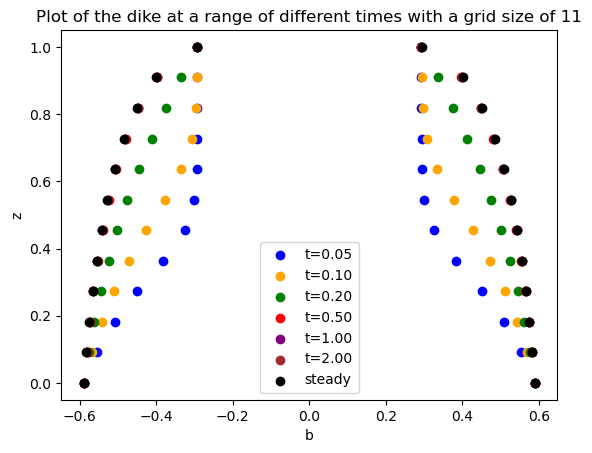

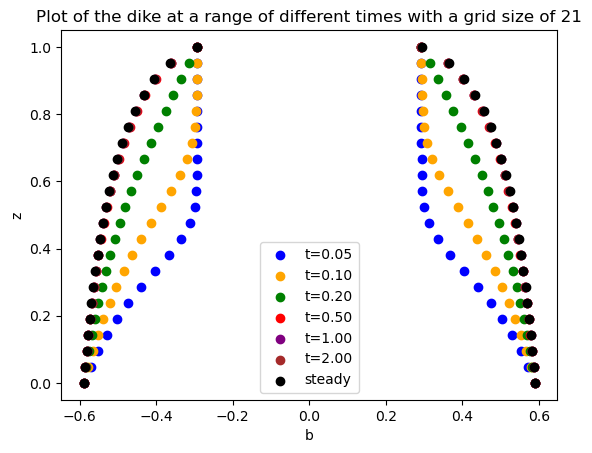

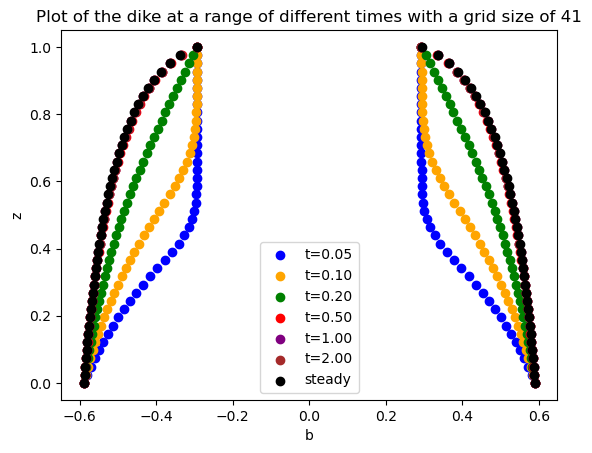

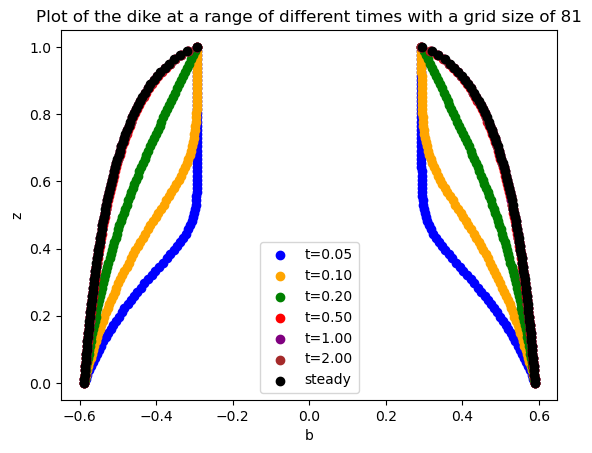

In [48]:
# Colours for each time 
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'black']

# Plot the dimension plots for the different grid sizes 
for grid, df in extracted_solutions:
    title = f'Plot of the dike at a range of different times with a grid size of {grid}'
    time_scatter = [times] * 2  # Each time has a positive and negative scatter]
    
    for time in range(1, len(df.columns)):
        # width_scatter as written does not make sense; let's clarify:
        # The time_scatter list has 12 elements (2x6), but df.columns[1:] has 6 time columns.
        # So, time_scatter is not consistent with the times in df.
        # You should use only the times present in df.columns[1:] (which correspond to the 'times' list).
        # The calculation width_scatter = df[time].values / 2 + -1 * df[time].values / 2
        # always results in an array of zeros, which is not meaningful for plotting.
        # If you want to plot the dike width at each time, you should plot +/- df[time].values/2 against df['z'].
        current_time = df.columns[time]
        current_color = colors[time - 1]
        plt.scatter(df[df.columns[time]].values / 2, df['z'], label=f'{df.columns[time]}', color=current_color)
        plt.scatter(-df[df.columns[time]].values / 2, df['z'], color=current_color)

    plt.xlabel('b')
    plt.ylabel('z')
    plt.title(title)
    plt.legend()
    plt.show()


### 2c): $L^2$ Norm

Considering the steady state solution to be exact for large times ($t>2$), we calculate error function defined
$$e(z,t) = b(z,t) - b_{numerical}(z,t)$$
where $b(z,t)$ is taken to be the steady state solution.


In [49]:
def trapezoidal_integration(x: list[float], y: list[float]) -> float:
    # Perform composite trapezoidal integration of y with respect to x
    integral = 0.0
    for i in range(1, len(x)):
        integral += (x[i] - x[i-1]) * (y[i] + y[i-1]) / 2
    return integral

def downsize(data: list[float], new_size: int) -> list[float]:
    # Downsize the resolution of the data assuming even spacing and equal limits
    factor = len(data) // new_size
    return [data[i * factor] for i in range(new_size)]

# A class to hold the numerical solutions and any further methods that need to be applied to them
class NumericalSolution(object):
    def __init__(self, z_values: list[float], time_values: list[float], b_values: list[list[float]], 
                 verbosity = 0):
        self.z_values = z_values
        self.time_values = time_values
        self.b_values = b_values

        self.grid_size = len(z_values)
        
        self.verbosity = verbosity

    def get_time_range(self) -> tuple[float, float]:
        # Return the time range of the solution
        return self.time_values[0], self.time_values[-1]
    
    def get_grid_spacing(self) -> float:
        # Return the grid spacing of the solution
        return self.z_values[1] - self.z_values[0]

    def steady(self) -> list[float]:
        # Return the presumed steady state solution at large time
        return self.b_values[-1]
    
    def difference(self, comparative: list[float]) -> list[float]:
        # Return the difference between the computed and comparative solutions
        return [c - s for c, s in zip(comparative, self.steady())]
    
    def l2_norm(self, comparative: list[float]) -> float:
        # Return the L2 norm of the difference between the computed and comparative solutions
        diff = self.difference(downsize(comparative, self.grid_size))

        if self.verbosity > 0:
            print(f'Difference: {diff}')

        squared_diffs = [d**2 for d in diff]
        integral = trapezoidal_integration(self.z_values, squared_diffs)

        self.l2_norm_value = np.sqrt(integral)
        return self.l2_norm_value

    def exact_residual(self, alpha: float) -> list[list[float]]:
        # Compute zr0 given the initial condition b(0,0) = bT
        bT = self.b_values[0][0]
        zr0 = 1/alpha * (bT - np.arctanh(bT))

In [50]:
# Create NumericalSolution objects for each grid size
numerical_solutions: dict[str, NumericalSolution] = {}
for grid, z_vals, t_vals, b_vals in solutions:
    numerical_solutions[grid] = NumericalSolution(z_vals, t_vals, b_vals)

In [51]:
for i in numerical_solutions:
    print(f'Grid size: {i}, L2 norm: {numerical_solutions[i].l2_norm(steady_solution["b"])}')

Grid size: 5, L2 norm: 0.10833976574915688
Grid size: 11, L2 norm: 0.05882683708813905
Grid size: 21, L2 norm: 0.03849035699478879
Grid size: 41, L2 norm: 0.037657917555286115
Grid size: 81, L2 norm: 0.02065415645264721


Line of best fit: y = 0.5486158380815684x + -1.4310179749357421


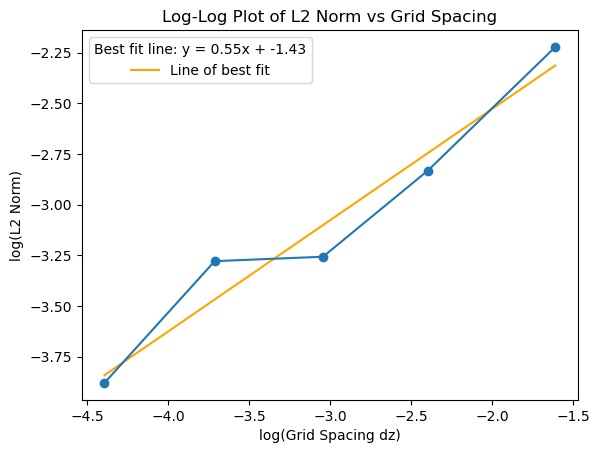

In [53]:
def plot_l2_norm(numerical_solutions: dict[str, NumericalSolution]):
    # Comparing the L2 Norm and the grid spacing dz
    grid_spacings = []
    l2_norms = []
    for grid, solution in numerical_solutions.items():
        dz = solution.get_grid_spacing()
        grid_spacings.append(dz)
        l2_norms.append(solution.l2_norm(steady_solution['b']))

    log_grid_spacings = np.log(grid_spacings)[:]
    log_l2_norms = np.log(l2_norms)[:]

    # Line of best fit
    coeffs = np.polyfit(log_grid_spacings, log_l2_norms, 1)
    print(f'Line of best fit: y = {coeffs[0]}x + {coeffs[1]}')
    poly = np.poly1d(coeffs)
    fit_values = poly(log_grid_spacings)
    plt.plot(log_grid_spacings, fit_values, label='Line of best fit', color='orange')



    plt.plot(log_grid_spacings, log_l2_norms, marker='o')
    plt.xlabel('log(Grid Spacing dz)')
    plt.ylabel('log(L2 Norm)')
    plt.title('Log-Log Plot of L2 Norm vs Grid Spacing')
    # Legend with equation of line of best fit
    plt.legend(title=f'Best fit line: y = {coeffs[0]:.2f}x + {coeffs[1]:.2f}')

    plt.show()

plot_l2_norm(numerical_solutions)


# 2d): Exact Solution
Given the exact solution
$$z - z_{r0} - ct = \frac{\beta}{\alpha}\left(b(z,t) - \sqrt{c/\alpha}\text{atanh}\left[\sqrt{(c/\alpha)}b(z,t)\right]\right)$$
we consider the residuals when the numerical solution is given as $b$. Note that we have $\alpha = c$ and $\beta = 1$ and so have further reduction
$$z - z_{r0} - ct = \frac{1}{\alpha}(b(z,t) - \text{atanh}(b(z,t)))$$
